# Logistic Regression
### Task 1
We are going to be using Logistic Regression in order to attempt to solve the problem of sentiment analysis. While this may not be the absolute best approach to this topic, I believe that it will do a sufficient job. This is because many individual words are highly correlated to the sentiment of the overall statement. For example the word "Amazing" being somewhere in a movie review typically indicates that it is a good review. If we take a bag of words approach to the problem the linear model can assign high weights to positive words and low weights to negative words thus allowing a basic way of assigning sentiment. This method failes to capture temporal and interword relations. For example "I really wished that the movie would be great, however this was not true" is a more intricate example that probably will not be well classified by this approach to the problem. 

## Data Analysis / Visualization
### Task 2
Dataset: http://ai.stanford.edu/~amaas/data/sentiment/ \
We are attempting to see how correlated certain words are to the sentiment of a positive movie review. To do this we will collect a count of the total occurences of certain words in positive examples as well as their total counts in the dataset overall. The graph below demonstrates that the occurences of certain individual words can be used to reason about how positive a certain review is. While using a bag of words approach to sentiment analysis takes away the temporal relationship between words logistic regression may well be a good method for simple examples as well as a good possible baseline for future models on this topic. We also remove words that have less than 100 total occurences in the dataset. This should allow the parameters of the model to be based off of words which we have sufficent data to reason about. It also prevents over-fitting to certain phrases that appear with low frequency, for example if "iiiii" appears once and the one apperance is of positive sentiment then Gradient Descent may make the weight related to this word extremely high so that all future occurences of this word are also classified as positive.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import string
import os

In [2]:
TOP_N_WORDS = 5000
PROVIDED_VOCAB_PATH = "/home/lenny/Documents/PROGRAMMING/CSCI4967/hw1/aclImdb/imdb.vocab"
VOCAB_PATH = "/home/lenny/Documents/PROGRAMMING/CSCI4967/hw1/vocab.txt"
TRAIN_PATH = "/home/lenny/Documents/PROGRAMMING/CSCI4967/hw1/aclImdb/train"
TEST_PATH = "/home/lenny/Documents/PROGRAMMING/CSCI4967/hw1/aclImdb/test"

In [3]:
##Construct a vocabulary using the top N words
f = open(PROVIDED_VOCAB_PATH, 'r')
vocab = f.readlines()[:TOP_N_WORDS]
vocab_list = [word.strip() for word in vocab]
word_index = { vocab_list[i] : i for i in range(len(vocab_list)) }
#print(word_index)
#print(vocab)

In [4]:
#Create the Updated Vocab (Remove Words with low occurence rate)
#Collect the total amount of % of times each word was seen in a postive/negative review
#score = total_pos_appearences/ total_apperances
POS_PATH = os.path.join(TRAIN_PATH, "pos")
NEG_PATH = os.path.join(TRAIN_PATH, "neg")
POSITIVE_EXAMPLES = os.listdir(POS_PATH)
NEGATIVE_EXAMPLES = os.listdir(NEG_PATH)
total_count = [0 for _ in range(len(vocab))]
positive_count = [0 for _ in range(len(vocab))]
for file in POSITIVE_EXAMPLES:
    f = open(os.path.join(POS_PATH, file), 'r')
    example = f.read().strip()
    example = example.translate(str.maketrans('','',string.punctuation))
    example = example.split()
    for word in example:
        if word in word_index:
            total_count[word_index[word]]+=1
            positive_count[word_index[word]]+=1
    f.close()
    
for file in NEGATIVE_EXAMPLES:
    f = open(os.path.join(NEG_PATH, file), 'r')
    example = f.read().strip()
    example = example.translate(str.maketrans('','',string.punctuation))
    example = example.split()
    for word in example:
        if word in word_index:
            total_count[word_index[word]]+=1
    f.close()
    
scores = [0.5 if total < 100 else pos/total for pos,total in zip(positive_count, total_count)]
#print(scores)



In [5]:
#Find Top 15 words 
zipped_index = sorted([(score, index) for index,score in zip(range(len(scores)), scores)], key=lambda x: (-x[0], -x[1]))
zipped_index = zipped_index[:7] + zipped_index[-7:]
#print(zipped_index)

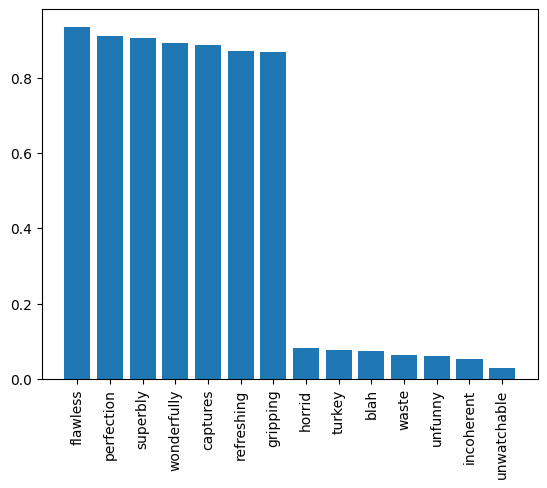

In [6]:
x = [vocab_list[item[1]] for item in zipped_index]
y = [item[0] for item in zipped_index]
plt.bar(x,y)
plt.xticks(rotation=90)
plt.show()

In [7]:
#Remove Words with less than 100 occurences
temp = []
for i, count in enumerate(total_count):
    if count >= 100:
        temp.append(vocab[i])

vocab = temp
word_index = { vocab_list[i] : i for i in range(len(vocab)) }

In [8]:
#Create Dataset using updated vocab 
DSET = []
for file in POSITIVE_EXAMPLES:
    f = open(os.path.join(POS_PATH, file), 'r')
    example = f.read().strip()
    example = example.translate(str.maketrans('','',string.punctuation))
    example = example.split()
    wc = [0 for _ in range(len(vocab))]
    for word in example:
        if word in word_index:
            wc[word_index[word]]+=1
    DSET.append((wc, 1))
    f.close()
    
for file in NEGATIVE_EXAMPLES:
    f = open(os.path.join(NEG_PATH, file), 'r')
    example = f.read().strip()
    example = example.translate(str.maketrans('','',string.punctuation))
    example = example.split()
    wc = [0 for _ in range(len(vocab))]
    for word in example:
        if word in word_index:
            wc[word_index[word]]+=1
    DSET.append((wc, 0))
    f.close()
    
random.shuffle(DSET)
#print(len(DSET))

## Implementing Logistic Regression
### Task 3
Now we are going to implement logistic regression. The two Gradient Descent Methods which we will use to train the model are stochastic gradient descent and minibatch gradient descent. After training with both methods we can see that SGD preforms better by a good margin. There are a few possible reasons for this. One is that SGD has more total effective parameter updates which could result in better overall preformance. This is especially true in a simple model where one example may give a lot of information to where a local minima is located. In other words the simplicity of the model results in the stochastic gradients which are really good representations of the real gradient of the model with respect to the whole dataset. I expect that adding momentum to SGD will amplify this affect improving the preformance more. Since Adam is essentially computing the sample first and second moments of the gradient I will implement it together with mini-batch gradient descent to give adam more accurate approximations of the gradient of the cost function. 

In [9]:
def sigmoid(x):
    return 1/(1+np.exp(-x + 3e-3))
    
def loss(X, Y_hat, Y):
    n = X.shape[1]
    eps = 1e-4
    loss = (-1/n) * np.sum( Y*np.log(Y_hat+ eps) + (1-Y)*np.log(1-Y_hat+ eps) )
    dW = (1/n) * X@(Y_hat-Y).T
    dB = (1/n) * np.sum(Y_hat - Y)
    return loss, dW, dB

class LogisticRegression:
    def __init__(self, num_features):
        self.W = np.random.normal(size=(num_features, 1))
        self.b = 0
    def __call__(self, X):
        return sigmoid(self.W.T@X + self.b)
#x = np.random.normal(size=(10,3))
#print(lm(x))
#loss(x, lm(x), np.array([[1, 1, 1]]))

In [10]:
##Train With MiniBatch Gradient Descent
def MiniBatch(lm, lr, lr_decay, batch_size, EPOCHS, verbose=True):
    loss_arr = []
    for e in range(EPOCHS):
        random.shuffle(DSET)
        running_loss = 0
        for i in range(len(DSET)//batch_size ):
            batch = DSET[i*batch_size: (i+1)*batch_size]
            X = np.array([x[0] for x in batch]).T
            Y = np.array([x[1] for x in batch])
            Y_hat = lm(X)
            l, dW, dB = loss(X,Y_hat,Y)
            lm.W -= lr*dW
            lm.b -= lr*dB
            running_loss += l
        lr *= lr_decay
        if e % 5 == 0 and verbose:
            print("Running Loss: ", running_loss/len(DSET))
            loss_arr.append(running_loss/len(DSET))
            
    return lm, loss_arr
    
def SGD(lm, lr, lr_decay, EPOCHS, verbose=True):
    loss_arr = []
    for e in range(EPOCHS):
        running_loss = 0
        random.shuffle(DSET)
        for i in range(len(DSET)):
            batch = DSET[i]
            X = np.array(batch[0]).reshape(-1, 1)
            Y = np.array(batch[1]).reshape(-1,1)
            Y_hat = lm(X)
            l, dW, dB = loss(X,Y_hat,Y)
            lm.W -= lr*dW
            lm.b -= lr*dB
            running_loss += l
        lr *= lr_decay
        if e % 5 == 0 and verbose:
            print("Running Loss: ", running_loss/len(DSET))
            loss_arr.append(running_loss/len(DSET))
    return lm, loss_arr

    


In [11]:
POS_PATH_TEST = os.path.join(TEST_PATH, "pos")
NEG_PATH_TEST = os.path.join(TEST_PATH, "neg")
POSITIVE_EXAMPLES_TEST = os.listdir(POS_PATH_TEST)
NEGATIVE_EXAMPLES_TEST = os.listdir(NEG_PATH_TEST)

def encode(str):
    str = str.translate(str.maketrans('','',string.punctuation))
    str = str.split()
    wc = [0 for _ in range(len(vocab))]
    for word in str:
        if word in word_index:
            wc[word_index[word]]+=1
    return np.array(wc).reshape(-1,1)

def get_test_accuracy(model):
    correct = 0
    total = 0
    for file in POSITIVE_EXAMPLES_TEST:
        f = open(os.path.join(POS_PATH_TEST, file), 'r')
        example = encode(f.read().strip())
        correct = correct+1 if model(example) > 0.5 else correct
        total +=1
        f.close()
        
    for file in NEGATIVE_EXAMPLES_TEST:
        f = open(os.path.join(NEG_PATH_TEST, file), 'r')
        example = encode(f.read().strip()).reshape(-1, 1)
        correct = correct+1 if model(example) <= 0.5 else correct
        total +=1
        f.close()
    return correct/total

def smooth(arr, a0, gamma):
    smoothed = []
    for i, item in enumerate(arr):
        a0 = a0*gamma + (1-gamma)*item
        smoothed.append(a0* (1/1-gamma**i))
    return smoothed
        
        
    

In [12]:
#Hyper Parameters
EPOCHS = 500
batch_size = 16
lr = .001
lr_decay = .999
lm_mb = LogisticRegression(len(vocab))
lm_sgd = LogisticRegression(len(vocab))

Running Loss:  0.20251553306461542
Running Loss:  0.15882513668087508
Running Loss:  0.13974175782642476
Running Loss:  0.12717727923900263
Running Loss:  0.11782908383077352
Running Loss:  0.11052576402626663
Running Loss:  0.10448515695255492
Running Loss:  0.09966575619191399
Running Loss:  0.09544830974744649
Running Loss:  0.091828960934358
Running Loss:  0.08877914667458411
Running Loss:  0.08588386608358305
Running Loss:  0.08325581874642217
Running Loss:  0.08091039338152714
Running Loss:  0.07877586520369495
Running Loss:  0.0768121382157461
Running Loss:  0.07488994958193115
Running Loss:  0.07316080751812894
Running Loss:  0.07166091021272901
Running Loss:  0.07012561651094483
Running Loss:  0.06884288568427613
Running Loss:  0.06754772243350403
Running Loss:  0.06634271966458741
Running Loss:  0.06513150135745319
Running Loss:  0.06415847393756574
Running Loss:  0.0630648580393264
Running Loss:  0.062129477420654014
Running Loss:  0.06118488679973791
Running Loss:  0.060304

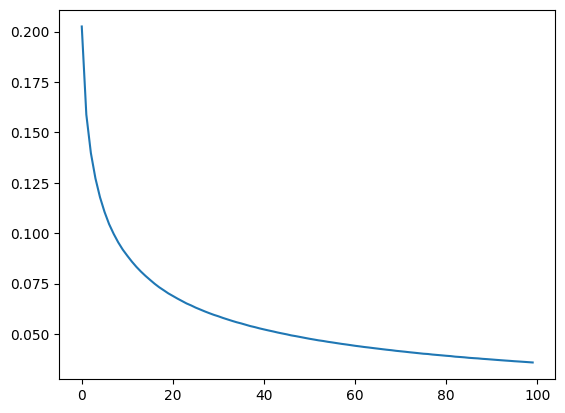

In [13]:
#TRAIN AND TEST MiniBatch
lm_mb, loss_arr = MiniBatch(lm_mb, lr, lr_decay, batch_size, EPOCHS, True)
print("TEST ACCURACY MiniBatch:", get_test_accuracy(lm_mb))
plt.plot([i for i in range(len(loss_arr))], loss_arr)
plt.show()

Running Loss:  2.423919595488387
Running Loss:  1.149461238538459
Running Loss:  0.8949175143163299
Running Loss:  0.7529093378449397
Running Loss:  0.6663802975085154
Running Loss:  0.6014502919361038
Running Loss:  0.5521315550884034
Running Loss:  0.5074101478500934
Running Loss:  0.4782011808430189
Running Loss:  0.44842900800920377
Running Loss:  0.4261878343658711
Running Loss:  0.4062050673083685
Running Loss:  0.3880213451372144
Running Loss:  0.37361957643708577
Running Loss:  0.35965136995303937
Running Loss:  0.3469472316232722
Running Loss:  0.33782463223625137
Running Loss:  0.3273367423014855
Running Loss:  0.3200292010298829
Running Loss:  0.3115442752988601
Running Loss:  0.30432641610005934
Running Loss:  0.2968137039889108
Running Loss:  0.29306984577678424
Running Loss:  0.28626906080215714
Running Loss:  0.28196103893934726
Running Loss:  0.27746015174887334
Running Loss:  0.27382429179118745
Running Loss:  0.2696170460152282
Running Loss:  0.26711427143089006
Runni

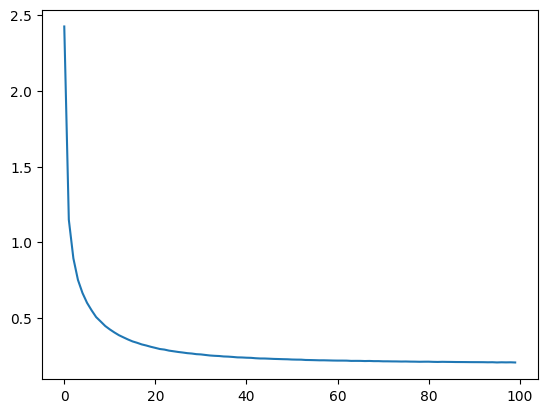

In [13]:
#TRAIN AND TEST SGD
lm_sgd, loss_arr = SGD(lm_sgd, lr, lr_decay, EPOCHS,True)
print("TEST ACCURACY SGD:", get_test_accuracy(lm_sgd))
plt.plot([i for i in range(len(loss_arr))], loss_arr)
plt.show()

## Optimizing the Optimizer
### Task 4
Before implementing any of the new algorithms I expect that adding momentum to SGD will result in better preformance as the moving average of the previous gradients will result in less variance in future gradients and thus allow the optimizer to converge quicker. Since Adam is essentially computing the sample first and second moments of the gradient I will implement it together with mini-batch gradient descent to give adam more accurate approximations of the gradient of the cost function. Both SGD with momentum and MiniBatch Gradient descent with Adam yield loss's which decrease faster over time indicating that the new optimization methods preform better. However due to the simplicity/convexity of the task both methods will converge to the same minima in the loss function. So overall no changes to the overall preformance are recorded (when you allow the model to train for enough time). That being said momentum and adam are still useful as they decrease the total amount of time needed until the model has reached the optimal parameters. Both of these optimizers will most likely be especially useful when working with models who do not have convex loss functions (Neural Networks).

In [14]:
def SGD_m(lm, lr, lr_decay, gamma, EPOCHS, verbose=True):
    loss_arr = []
    dW_t = np.zeros(lm.W.shape)
    dB_t = 0
    for e in range(EPOCHS):
        running_loss = 0
        random.shuffle(DSET)
        for i in range(len(DSET)):
            batch = DSET[i]
            X = np.array(batch[0]).reshape(-1, 1)
            Y = np.array(batch[1]).reshape(-1,1)
            Y_hat = lm(X)
            l, dW, dB = loss(X,Y_hat,Y)
            dW_t = gamma*dW_t + lr*dW
            dB_t = gamma*dB_t + lr*dB
            lm.W -= dW_t
            lm.b -= dB_t
            running_loss += l
        lr *= lr_decay
        if e % 5 == 0 and verbose:
            print("Running Loss: ", running_loss/len(DSET))
            loss_arr.append(running_loss/len(DSET))
    return lm, loss_arr

def MiniBatch_Adam(lm, lr, lr_decay, B_1, B_2, batch_size, EPOCHS, verbose=True):
    loss_arr = []
    MW_t = np.zeros(lm.W.shape)
    VW_t = np.zeros(lm.W.shape)
    MB_t = 0
    VB_t = 0
    for e in range(EPOCHS):
        random.shuffle(DSET)
        running_loss = 0
        for i in range(len(DSET)//batch_size):
            batch = DSET[i*batch_size: (i+1)*batch_size]
            X = np.array([x[0] for x in batch]).T
            Y = np.array([x[1] for x in batch])
            Y_hat = lm(X)
            l, dW, dB = loss(X,Y_hat,Y)
            MW_t = B_1 * MW_t + (1-B_1)*dW
            VW_t = B_2 * VW_t + (1-B_2)*(dW*dW)
            MB_t = B_1 * MB_t + (1-B_1)*dB
            VB_t = B_2 * VB_t + (1-B_2)*(dB*dB)
            t = (e+1) * (len(DSET)//batch_size) + i
            mc = 1/(1-B_1**t)
            vc = 1/(1-B_2**t)
            lm.W -= lr*mc*MW_t/(np.sqrt(VW_t*vc) + 1e-8)
            lm.b -= lr*mc*MB_t/(np.sqrt(VB_t*vc) + 1e-8)
            running_loss += l
        lr *= lr_decay
        if e % 5 == 0 and verbose:
            print("Running Loss: ", running_loss/len(DSET))
            loss_arr.append(running_loss/len(DSET))
    return lm, loss_arr

Running Loss:  1.8427716523426454
Running Loss:  0.9047915488656402
Running Loss:  0.6679745069615997
Running Loss:  0.5170604921713049
Running Loss:  0.4287254089549255
Running Loss:  0.375629704339377
Running Loss:  0.341889600972599
Running Loss:  0.3256250797245469
Running Loss:  0.31711404634191437
Running Loss:  0.3105555171663755
Running Loss:  0.3072678750306289
Running Loss:  0.30526303706004815
Running Loss:  0.30399669029964693
Running Loss:  0.3031843956567361
Running Loss:  0.30323896521362925
Running Loss:  0.30292354814990224
Running Loss:  0.3028275990396331
Running Loss:  0.30274137708228127
Running Loss:  0.30269352095509805
Running Loss:  0.30265227737365
Running Loss:  0.30262216726828817
Running Loss:  0.30260998392434807
Running Loss:  0.3026017882410825
Running Loss:  0.30259801909154854
Running Loss:  0.3025972890770753
Running Loss:  0.302595535857135
Running Loss:  0.30259498530568296
Running Loss:  0.30259406532447636
Running Loss:  0.30259390581807927
Runnin

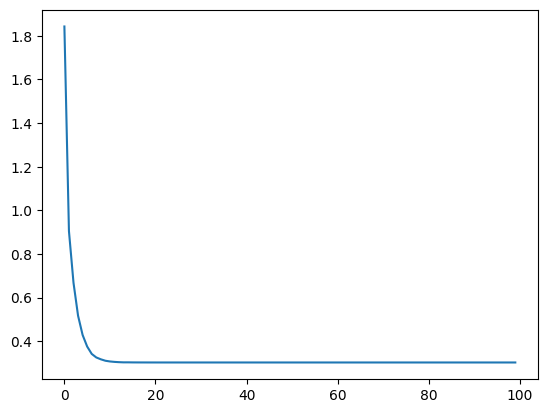

In [15]:
lm_sgdm = LogisticRegression(len(vocab))
lm_sgdm, loss_arr = SGD_m(lm_sgdm, .0005, 0.9, 0.99, EPOCHS,True)
print("TEST ACCURACY SGD Momentum:", get_test_accuracy(lm_sgdm))
plt.plot([i for i in range(len(loss_arr))], loss_arr)
plt.show()

Running Loss:  0.05057721451538885
Running Loss:  0.04135111188537484
Running Loss:  0.03597020004856622
Running Loss:  0.0322680735662259
Running Loss:  0.02972936848438722
Running Loss:  0.027975476037504336
Running Loss:  0.026730299746351407
Running Loss:  0.025781986856560125
Running Loss:  0.025106542558679844
Running Loss:  0.02459530244056339
Running Loss:  0.02420542357369743
Running Loss:  0.023932387298820117
Running Loss:  0.02372107205168577
Running Loss:  0.02355858995259406
Running Loss:  0.023440574248426865
Running Loss:  0.02331579481781761
Running Loss:  0.023254166611395725
Running Loss:  0.023201993742689612
Running Loss:  0.023158821528690237
Running Loss:  0.023118134039952457
Running Loss:  0.02310008262907607
Running Loss:  0.02305597160193411
Running Loss:  0.023047315842992588
Running Loss:  0.02303481383839067
Running Loss:  0.02303505684277839
Running Loss:  0.02302859195925691
Running Loss:  0.023010412311663734
Running Loss:  0.023006472870769568
Running 

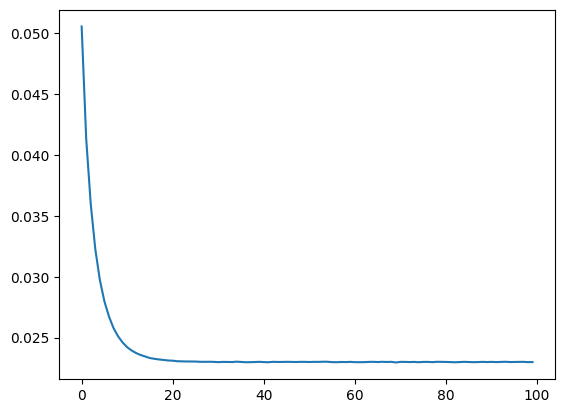

In [16]:
lm_adam = LogisticRegression(len(vocab))
lm_adam, loss_arr = MiniBatch_Adam(lm_adam, .0003, .95 , 0.9, 0.999, 64, EPOCHS,True)
print("TEST ACCURACY ADAM:", get_test_accuracy(lm_adam))
plt.plot([i for i in range(len(loss_arr))], loss_arr)
plt.show()